In [39]:
from datasets import load_dataset

mnist = load_dataset("mnist")

In [40]:
mnist["train"]["image"][1]

In [41]:
mnist["train"]["label"][1]

0

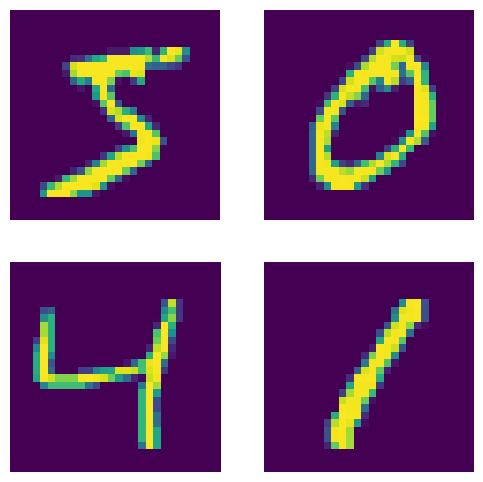

In [42]:
from genaibook.core import show_images

show_images(mnist["train"]["image"][:4])

In [43]:
from torchvision import transforms

def mnist_to_tensor(samples):
    t = transforms.ToTensor()
    samples["image"] = [t(img) for img in samples["image"]]
    return samples

In [44]:
mnist = mnist.with_transform(mnist_to_tensor)
mnist["train"] = mnist["train"].shuffle(seed=42)

In [45]:
x = mnist["train"]["image"][0]
x.min(), x.max()

(tensor(0.), tensor(1.))

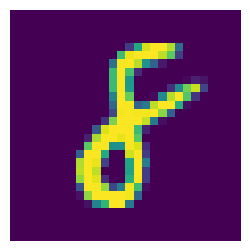

In [46]:
show_images(mnist["train"]["image"][0])

In [47]:
from torch.utils.data import DataLoader

bs = 64
train_dataloader = DataLoader(mnist["train"]["image"], batch_size=bs)

In [48]:
from torch import nn

def conv_block(in_channels, out_channels, kernel_size=4, stride=2, padding=1):
    return nn.Sequential(
        nn.Conv2d(
            in_channels, 
            out_channels, 
            kernel_size=kernel_size, 
            stride=stride, 
            padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
    )

In [49]:
class Encoder(nn.Module):
    def __init__(self, in_channels, latent_dims):
        super().__init__()
        self.conv_layers = nn.Sequential(
            conv_block(in_channels, 128),
            conv_block(128, 256),
            conv_block(256, 512),
            conv_block(512, 1024),
        )
        self.linear = nn.Linear(1024, latent_dims)
    
    def forward(self, x):
        bs = x.shape[0]
        x = self.conv_layers(x)
        x = self.linear(x.reshape(bs, -1))
        return x

In [50]:
mnist["train"]["image"][0].shape

torch.Size([1, 28, 28])

In [52]:
in_channels = 1
x = mnist["train"]["image"][0][None, :]
encoder = Encoder(in_channels, 2).eval()

encoded = encoder(x)
encoded.shape

torch.Size([1, 2])

In [53]:
encoded

tensor([[0.0088, 0.0276]], grad_fn=<AddmmBackward0>)

In [56]:
batch = next(iter(train_dataloader))
encoded = Encoder(in_channels=1, latent_dims=2)(batch)
batch.shape, encoded.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64, 2]))

In [57]:
def conv_transpose_block(
    in_channels,
    out_channels,
    kernel_size=3,
    stride=2,
    padding=1,
    output_padding=0,
    with_act=True,
):
    modules = [
        nn.ConvTranspose2d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            output_padding=output_padding,
        ),
        nn.BatchNorm2d(out_channels),
    ]
    if with_act:
        modules.append(nn.BatchNorm2d(out_channels))
        modules.append(nn.ReLU())
    return nn.Sequential(*modules)

In [58]:
class Decoder(nn.Module):
    def __init__(self, out_channels, latent_dims):
        super().__init__()
        self.linear = nn.Linear(latent_dims, 1024 * 4 * 4)
        self.t_conv_layers = nn.Sequential(
            conv_transpose_block(1024, 512),
            conv_transpose_block(512, 256, output_padding=1),
            conv_transpose_block(256, out_channels, output_padding=1, with_act=False),
        )
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        bs = x.shape[0]
        x = self.linear(x)
        x = x.reshape((bs, 1024, 4, 4))
        x = self.t_conv_layers(x)
        x = self.sigmoid(x)
        return x

In [61]:
decoded_batch = Decoder(x.shape[0], latent_dims=2)(encoded)
decoded_batch.shape

torch.Size([64, 1, 28, 28])

In [64]:
class AutoEncoder(nn.Module):
    def __init__(self, in_channels, latent_dims):
        super().__init__()
        self.encoder = Encoder(in_channels, latent_dims)
        self.decoder = Decoder(in_channels, latent_dims)
        
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, x):
        return self.decoder(x)
    
    def forward(self, x):
        return self.decode(self.encode(x))

In [66]:
model = AutoEncoder(1, 2)

In [67]:
import torchsummary

torchsummary.summary(model, input_size=(1, 28, 28), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 14, 14]           2,176
       BatchNorm2d-2          [-1, 128, 14, 14]             256
              ReLU-3          [-1, 128, 14, 14]               0
            Conv2d-4            [-1, 256, 7, 7]         524,544
       BatchNorm2d-5            [-1, 256, 7, 7]             512
              ReLU-6            [-1, 256, 7, 7]               0
            Conv2d-7            [-1, 512, 3, 3]       2,097,664
       BatchNorm2d-8            [-1, 512, 3, 3]           1,024
              ReLU-9            [-1, 512, 3, 3]               0
           Conv2d-10           [-1, 1024, 1, 1]       8,389,632
      BatchNorm2d-11           [-1, 1024, 1, 1]           2,048
             ReLU-12           [-1, 1024, 1, 1]               0
           Linear-13                    [-1, 2]           2,050
          Encoder-14                   

In [71]:
import torch
from matplotlib import pyplot as plt
from torch.nn import functional as F
from tqdm.notebook import tqdm, trange

from genaibook.core import get_device

device = get_device()

In [ ]:
# Missing training function and step here

In [70]:
def train(model, num_epochs=10, lr=1e-4):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, eps=1e-5)
    
    model.train()
    losses = []
    for _ in (progress := trange(num_epochs, desc="Training")):
        for _, batch in (
            inner := tqdm(
                enumerate(train_dataloader), total=len(train_dataloader)
            )
        ):
            batch = batch.to(device)
            
            preds = model(batch)
            
            loss = F.mse_loss(preds, batch)
            
            inner.set_postfix(loss=f"{loss.cpu().item():.3f}")
            losses.append(loss.item())
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        progress.set_postfix(loss=f"{loss.cpu().item():.3f}", lr=f"{lr:.0e}")
    return losses

In [72]:
ae_model = AutoEncoder(in_channels=1, latent_dims=2)
ae_model.to(device)

AutoEncoder(
  (encoder): Encoder(
    (conv_layers): Sequential(
      (0): Sequential(
        (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (1): Sequential(
        (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (2): Sequential(
        (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (3): Sequential(
        (0): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (linear): Linear(in_

In [ ]:
losses = train(ae_model)

Training:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

In [ ]:
plt.plot(losses)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss Curve (two latent dimensions)")
plt.show()

In [ ]:
eval_bs = 16
eval_dataloader = DataLoader(mnist["test"]["image"], batch_size=eval_bs)

In [ ]:
ae_model.eval()
with torch.inference_mode():
    eval_batch = next(iter(eval_dataloader))
    predicted = ae_model(eval_batch.to(device)).cpu()

In [ ]:
batch_vs_preds = torch.cat((eval_batch, predicted))
show_images(batch_vs_preds, imsize=1, nrow=2)

In [ ]:
images_labels_dataloader = DataLoader(mnist["test"], batch_size=512)

In [ ]:
import pandas as pd

df = pd.DataFrame(
    {
        "x": [],
        "y": [],
        "label": [],
    }
)

for batch in tqdm(
    iter(images_labels_dataloader), total=len(images_labels_dataloader)
):
    encoded = ae_model.encode(batch["image"].to(device)).cpu()
    new_items = {
        "x": [t.tiem() for t in encoded[:, 0]],
        "y": [t.item() for t in encoded[:, 1]],
        "label": batch["label"],
    }
    df = pd.concat([df, pd.DataFrame(new_items)], ignore_index=True)

In [ ]:
plt.figure(figsize=(10, 8))

for label in range(10):
    points = df[df["label"] == label]
    plt.scatter(points["x"], points["y"], label=str(label), marker=".")
    
plt.legend()